In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import numpy as np
import math
import itertools

from scipy import signal

import matplotlib.pyplot as plt

# Toy example one hot vector (one-sided)

In this example we want to prove the importance method with a one-hot datset so that we are not dealing with an ill-posed solution, like with the numbered class labels.

In [2]:
def onehot_data(shape=(2**21, 10), distribution=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]):
    '''
    The function to make the dataset
    
    Parameters:
    shape (tuple): the shape of the generated dataset
    distribution (list): a list of probabilities for each of the classes in the dataset
    '''
    
    # make probabilities sum to one
    distribution = np.array(distribution)
    distribution /= distribution.sum()
    
    # make a one hot dataset according to the given distribution
    data = torch.zeros(shape)
    
    last_i = 0
    for i in range(shape[1]):
        amount = math.floor(distribution[i]*shape[0])
        data[last_i: last_i+amount, i] = 1
        last_i += amount
        
    # shuffle
    idx = torch.randperm(shape[0]) 
    data = data[idx]
    
    return data.cuda()

In [3]:
class OnehotDataset(Dataset):
    '''The dataloader for the one hot dataset
    '''
    
    def __init__(self, distribution=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]):
        '''
        Parameters:
        distribution (list): a list of probabilities for each of the classes in the dataset
        '''

        self.distribution = distribution
        self.dataset = onehot_data(distribution=self.distribution)
        self.example_imgs = self.example()
        
    def example(self):
        '''
        Returns an example for each class in the domain
        '''       
        return torch.eye(len(self.distribution))

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

In this example we have 2 domains with 10 classes. Only the first two classes have a different probability.

In [4]:
batch_size = 1024

# Settings for domain A
ratio_A = 0.2
dataset_A = OnehotDataset(distribution=[0.01, 0.19, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
dataloader_A = DataLoader(dataset_A, batch_size, shuffle=True)

# Settings for domain B
ratio_B = 0.5
dataset_B = OnehotDataset(distribution=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
dataloader_B = DataLoader(dataset_B, batch_size, shuffle=True)

In [5]:
class WeightNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(WeightNet, self).__init__()
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(10, 1)
        self.softmax = nn.Softmax(0)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x))
        out = self.fc2(h1)
        return self.softmax(out)

In [6]:
# Initialize the networks
weight_network = WeightNet().cuda()

# Initialize the optimizers
lr = 0.001
optimizer_w = optim.Adam(weight_network.parameters(), lr=lr)

# For storing results
losses_w = []

mean_A = []
mean_B = []

Lminusses = []
Lplusses = []

example_importances_A = []

def weight_normalization(w):
    return w
#     return 0.5*(1 + w)

def f(x, w):
    return x.mean() * w

for epoch in range(1):
    for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):
        
        # The weighting process
        w = weight_network(real_A)
    
        # The loss function --------------------------------------------------------------------------------
        
        Lmin = (real_A * w).sum(0)
        Lplus = real_B.mean(0)
        
        loss_w = ((Lmin - Lplus)**2).sum()**(1/2)
        
        mean_A += [real_A.mean(0)]
        mean_B += [real_B.mean(0)]
        
        # ---------------------------------------------------------------------------------------------------

        # Backward
        optimizer_w.zero_grad()
        loss_w.backward()
        optimizer_w.step()   

        # Store values --------------------------------------------------------------------------------------
        Lminusses += [Lmin.cpu().detach().numpy()]
        Lplusses += [Lplus.cpu().detach().numpy()]
        
        losses_w += [loss_w.item()]
        
        w_a = weight_normalization(weight_network(dataset_A.example_imgs.cuda()))
        example_importances_A += [[importance.item() for importance in w_a]] # Store examples in a list

        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 500 == 0:
            print('step', i, 'loss_w: ', loss_w.item())
            
        if i % 10000 == 0 and i != 0:
            break

step 0 loss_w:  0.13623173534870148
step 500 loss_w:  0.10846821218729019
step 1000 loss_w:  0.05308341234922409
step 1500 loss_w:  0.050324246287345886
step 2000 loss_w:  0.038353342562913895


## Results
In the plot below we see that the loss of W is going down.

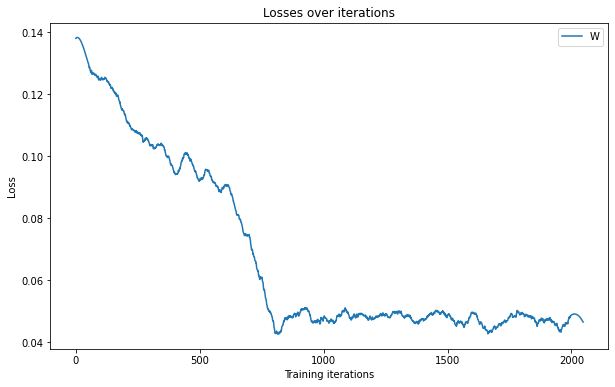

In [7]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
# plt.yscale('symlog')
smoothed_losses_w = signal.savgol_filter(losses_w,101,3)
plt.plot(smoothed_losses_w)
plt.legend(['W'])
plt.show()

The plot below shows that the classes 0 and 1 in domain A are weighted to match the uniform distribution in domain B.

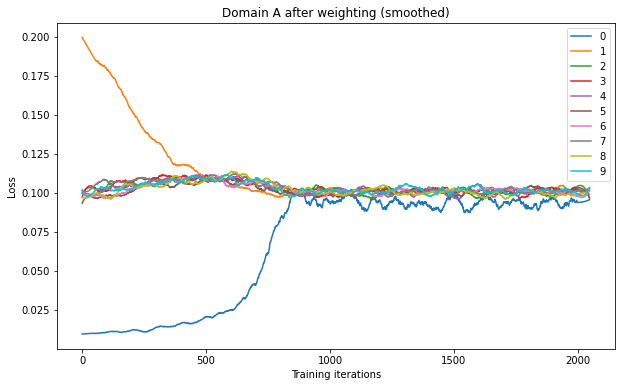

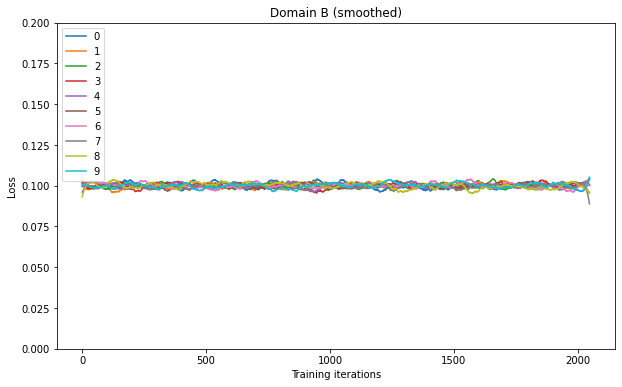

In [8]:
plt.figure(figsize=(10,6))
plt.title('Domain A after weighting (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
smoothed_Lmin = signal.savgol_filter(Lminusses,101,3,axis=0)
plt.plot(smoothed_Lmin)
plt.legend(np.arange(10))
plt.show()

plt.figure(figsize=(10,6))
plt.title('Domain B (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.ylim(ymax = 0.2, ymin = 0)
smoothed_Lplus = signal.savgol_filter(Lplusses,101,3,axis=0)
plt.plot(smoothed_Lplus)
plt.legend(np.arange(10))
plt.show()

Here you see the weights assigned to the classes in domain A. As expected, 0 gets a large weight as it is underrepresented in domain A, and 1 gets a small weight as it is overrepresented in domain A.

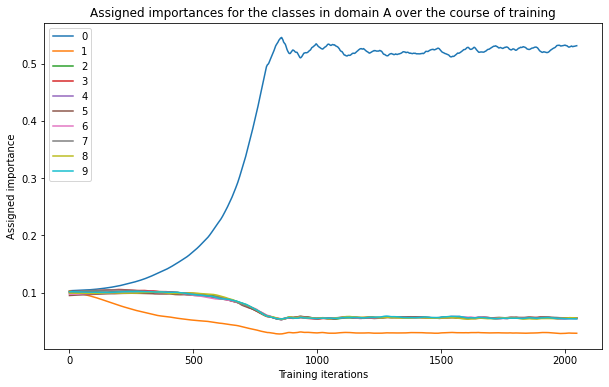

In [9]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the classes in domain A over the course of training')
plt.plot(example_importances_A)
plt.legend(np.arange(10))
plt.ylabel('Assigned importance')
plt.xlabel('Training iterations')
plt.show()